# [Sutton and Barto Notebooks](https://github.com/seungjaeryanlee/sutton-barto-notebooks): Figure 2.6

[모두AI](https://www.modu.ai)  
저자: 이승재  

![Figure 2.6](figure_2_6.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def argmax_all(list_):
    """
    주어진 list의 최대값들의 index들을 list 형태로 반환합니다. 첫 최대값의 index만 반환하는
    np.argmax와는 다릅니다.
    """
    return np.argwhere(list_ == list_.max()).flatten()

## Environment

![Figure 2.1](figure_2_1.png)

In [3]:
class Environment:
    """
    Figure 2.1에서 보여진 10개의 행동이 가능한 Bandit의 변형입니다. 이제 보상 분포의
    기대값들은 평균 0이 아니라 평균 4의 분포에서 고릅니다.
    """

    def __init__(self, n_actions=10):
        self.action_space = [i for i in range(n_actions)]
        self.distributions = []
        for _ in range(n_actions):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

    def step(self, action):
        """
        주어진 행동에 대한 보상을 반환합니다.
        """
        mean, stddev = self.distributions[action]
        reward = np.random.normal(loc=mean, scale=stddev)
        return reward

    def reset(self):
        """
        환경의 보상 분포들을 재설정합니다.
        """
        self.distributions = []
        for _ in range(len(self.action_space)):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

## Agent

In [4]:
class EpsilonGreedyAgent:
    """
    엡실론 탐욕 에이전트입니다.
    """
    name = '$\\epsilon$-greedy'

    def __init__(self, action_space, parameter=0):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.epsilon = parameter

    def get_action(self):
        """
        엡실론 탐욕 정책으로 행동을 선택합니다.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            return np.random.choice(argmax_all(self.q))

    def update(self, action, reward):
        """
        주어진 행동과 보상으로 Q값을 업데이트합니다.
        """
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        에이전트의 Q값들을 0으로 재설정합니다.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

In [5]:
class OptimisticAgent:
    """
    엡실론 탐욕 에이전트입니다.
    """
    name = 'Optimistic'

    def __init__(self, action_space, parameter=0, epsilon=0, learning_rate=0.9):
        self.action_space = action_space
        self.initial_q = parameter
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.q = np.full(len(action_space), self.initial_q, dtype=np.float64)

    def get_action(self):
        """
        엡실론 탐욕 정책으로 행동을 선택합니다.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            return np.random.choice(argmax_all(self.q))

    def update(self, action, reward):
        """
        주어진 행동과 보상으로 Q값을 업데이트합니다.
        """
        self.q[action] += self.learning_rate * (reward - self.q[action])

    def reset(self):
        """
        에이전트의 Q값들을 0으로 재설정합니다.
        """
        self.q = np.full(len(self.action_space),
                         self.initial_q, dtype=np.float64)

In [6]:
class UCBAgent:
    """
    UCB 에이전트입니다.
    """
    name = 'UCB'

    def __init__(self, action_space, parameter=0):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.total_action = 0
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.ucb_c = parameter

    def get_action(self):
        """
        UCB로 탐욕적으로 행동을 선택합니다.
        """
        ucb_terms = np.zeros(len(self.action_space))
        for action in self.action_space:
            if self.action_counts[action] == 0:
                ucb_terms[action] = float("inf")
            else:
                sqrt_term = np.sqrt(
                    np.log(self.total_action) / self.action_counts[action])
                ucb_terms[action] = (self.ucb_c * sqrt_term)

        best_actions = argmax_all(self.q + ucb_terms)

        return np.random.choice(best_actions)

    def update(self, action, reward):
        """
        주어진 행동과 보상으로 Q값을 업데이트합니다.
        """
        self.total_action += 1
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        에이전트의 Q값들을 0으로 재설정합니다.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

In [7]:
class PreferenceAgent:
    """
    선호 기반 에이전트입니다.
    """
    name = 'Gradient'

    def __init__(self, action_space, parameter=0.9):
        self.action_space = action_space
        self.learning_rate = parameter
        self.h = np.zeros(len(action_space), dtype=float)
        self.action_count = 0

        self.baseline = 0

    def get_action_p(self):
        """
        H값으로부터 행동을 고를 확률을 계산합니다.
        """
        e_h = np.exp(self.h)
        return e_h / np.sum(e_h)

    def get_action(self):
        """
        선호도를 고려하여 행동을 선택합니다.
        """
        return np.random.choice(self.action_space, p=self.get_action_p())

    def update(self, action, reward):
        """
        주어진 행동과 보상으로 H값을 업데이트합니다.
        """
        action_p = self.get_action_p()

        self.action_count += 1
        self.baseline += (reward - self.baseline) / self.action_count
        baseline = self.baseline

        for a in self.action_space:
            if action == a:
                self.h[a] += self.learning_rate * \
                    (reward - baseline) * (1 - action_p[a])
            else:
                self.h[a] -= self.learning_rate * \
                    (reward - baseline) * action_p[a]

    def reset(self):
        """
        에이전트의 H값들을 0으로 재설정합니다.
        """
        self.h = np.zeros(len(self.action_space), dtype=float)

## Plots

In [8]:
def run(env, agent, n_steps=1000):
    """
    Bandit 환경에서 n_steps 번 행동을 합니다. 이것을 하나의 '실행'이라 합니다. 총 보상을
    반환합니다.
    """
    actions = np.zeros(n_steps, dtype=int)
    sum_reward = 0
    for i in range(n_steps):
        actions[i] = agent.get_action()
        reward = env.step(actions[i])
        agent.update(actions[i], reward)
        sum_reward += reward

    return sum_reward

In [9]:
def plot(agents, n_runs=10, n_steps=1000):
    """
    각 에이전트마다 주어진 매개변수를 사용 시 평균 보상 그래프를 그립니다.
    """
    names = []

    envs = [Environment() for _ in range(n_runs)]
    
    for Agent, param_values in agents:
        names.append(Agent.name)

        average_rewards = []
        for param_value in param_values:
            sum_reward = 0
            for env in envs:
                agent = Agent(env.action_space, parameter=param_value)
                sum_reward += run(env, agent, n_steps)

            average_rewards.append(sum_reward / (n_runs * n_steps))

        plt.semilogx(param_values, average_rewards, basex=2)

    plt.legend(names)
    plt.xlabel('Hyperparameter values')
    plt.xticks([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4])
    plt.ylabel('Average reward over {} steps'.format(n_steps),
               rotation='horizontal',
               ha='right')
    # plt.savefig('plot.png')
    plt.show()

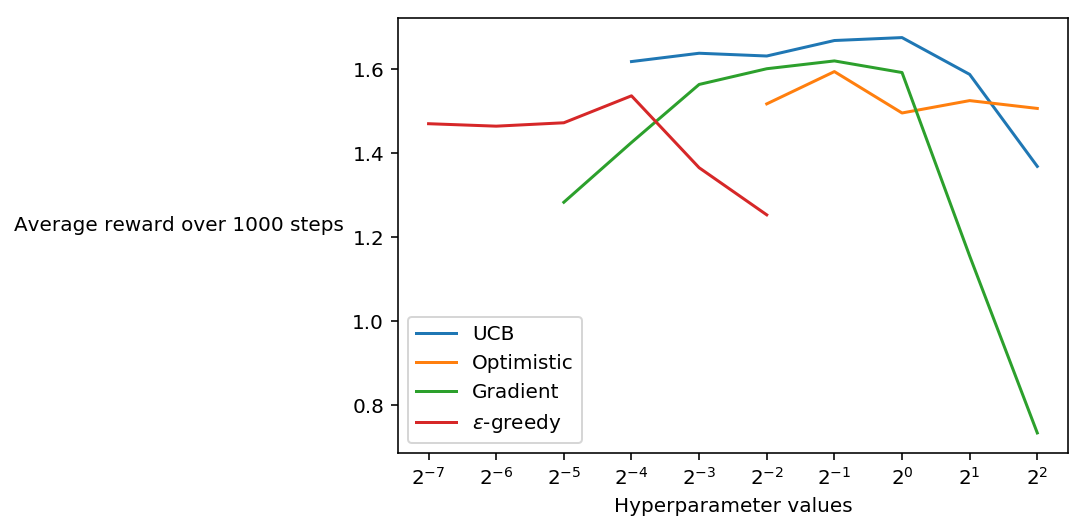

In [10]:
np.random.seed(7)
env = Environment()
agents = [
    (UCBAgent, [1/16, 1/8, 1/4, 1/2, 1, 2, 4]),
    (OptimisticAgent, [1/4, 1/2, 1, 2, 4]),
    (PreferenceAgent, [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]),
    (EpsilonGreedyAgent, [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]),
]
plot(agents)